In [5]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import multilabel_confusion_matrix
from shutil import copyfile
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
!pip3 install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [7]:
os.getcwd()

'/content'

In [6]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Specifically check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available: {gpus}")
else:
    print("GPU is not available.")

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [7]:

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/content/tf_certify_prep/cats_vs_dogs/cats_dogs.zip"



--2024-04-29 21:11:30--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.61.210.15, 2600:1406:3c:3a4::317f, 2600:1406:3c:393::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.61.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/tf_certify_prep/cats_vs_dogs/cats_dogs.zip’

/content/tf_certify 100%[===================>] 786.67M   212MB/s    in 3.7s    

2024-04-29 21:11:34 (212 MB/s) - ‘/content/tf_certify_prep/cats_vs_dogs/cats_dogs.zip’ saved [824887076/824887076]



In [8]:
local_zip = '/content/tf_certify_prep/cats_vs_dogs/cats_dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/tf_certify_prep/cats_vs_dogs')
zip_ref.close()


In [9]:
source_path = '/content/tf_certify_prep/cats_vs_dogs/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

find: ‘/tmp/PetImages/’: No such file or directory
There are 12501 images of dogs.
There are 12501 images of cats.


In [10]:
root_dir = '/content/tf_certify_prep/cats_vs_dogs/train_valid_split'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    os.makedirs(os.path.join(root_path, 'training'))
    os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
    os.makedirs(os.path.join(root_path, 'testing'))
    os.makedirs(os.path.join(f'{root_path}/testing', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/testing', 'cats'))

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [11]:

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))


/content/tf_certify_prep/cats_vs_dogs/train_valid_split/testing
/content/tf_certify_prep/cats_vs_dogs/train_valid_split/training
/content/tf_certify_prep/cats_vs_dogs/train_valid_split/testing/cats
/content/tf_certify_prep/cats_vs_dogs/train_valid_split/testing/dogs
/content/tf_certify_prep/cats_vs_dogs/train_valid_split/training/cats
/content/tf_certify_prep/cats_vs_dogs/train_valid_split/training/dogs


In [12]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)
  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING


In [14]:

# Define paths
CAT_SOURCE_DIR = "/content/tf_certify_prep/cats_vs_dogs/PetImages/Cat/"
DOG_SOURCE_DIR = '/content/tf_certify_prep/cats_vs_dogs/PetImages/Dog/'

TRAINING_DIR = '/content/tf_certify_prep/cats_vs_dogs/train_valid_split/training/'
TESTING_DIR = '/content/tf_certify_prep/cats_vs_dogs/train_valid_split/testing/'

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


In [17]:
del history, model_training, train_val_generators, model_build

In [1]:
11250/45

250.0

In [2]:
1250/5

250.0

In [18]:
def train_val_generators(TRAINING_DIR, TESTING_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=45, class_mode='binary', target_size=(150, 150))
    # save_to_dir=/tmp/img-data-gen-outputs

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                  batch_size=5, class_mode='binary', target_size=(150, 150))

    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        # tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        # tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

#How to set up a CV loop for a computer vision problem?

def model_training(EPOCHS, model_checkpoint_path):
    import datetime
    start_time = datetime.datetime.now()
    train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)
    callbacks = myCallback()
    model = model_build()
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
    #                                             patience=patience,
    #                                             mode='min')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor='loss', mode='min', save_best_only=True)
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, verbose=1, callbacks=[callbacks, model_checkpoint])
    end_time = datetime.datetime.now()
    print("Training time: ", end_time - start_time)
    return history

In [19]:

model_checkpoint_path = '/content/tf_certify_prep/cats_vs_dogs/conv2d_stacked_model.h5'
history = model_training(10, model_checkpoint_path)



Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.
Epoch 1/15
500/500 [==============================] - 139s 276ms/step - loss: 0.6512 - accuracy: 0.6119 - val_loss: 0.5744 - val_accuracy: 0.7015
Epoch 2/15
500/500 [==============================] - 138s 276ms/step - loss: 0.5931 - accuracy: 0.6788 - val_loss: 0.5481 - val_accuracy: 0.7179
Epoch 3/15
500/500 [==============================] - 138s 276ms/step - loss: 0.5581 - accuracy: 0.7132 - val_loss: 0.5060 - val_accuracy: 0.7467
Epoch 4/15
500/500 [==============================] - 138s 276ms/step - loss: 0.5334 - accuracy: 0.7311 - val_loss: 0.4882 - val_accuracy: 0.7671
Epoch 5/15
500/500 [==============================] - 138s 276ms/step - loss: 0.5151 - accuracy: 0.7458 - val_loss: 0.4503 - val_accuracy: 0.7851
Epoch 6/15
500/500 [==============================] - 137s 274ms/step - loss: 0.4976 - accuracy: 0.7589 - val_loss: 0.4082 - val_accuracy: 0.8099
Epoch 7/15
500/500 [===================

In [20]:

def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['accuracy'], label='training_accuracy')
    plt.plot(history['val_accuracy'], label='validation_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='lower right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


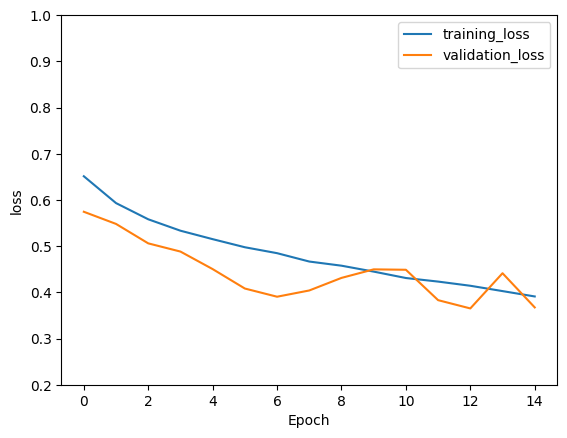

In [21]:
plot_learning_curve_loss(history.history, 0.2, 1)

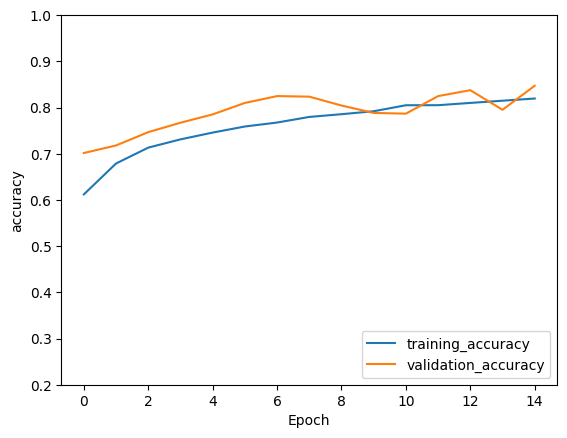

In [22]:
plot_learning_curve_metric(history.history, 0.2, 1)

In [ ]:
Training time for the above two plots

Epoch 15/15
500/500 [==============================] - 138s 276ms/step - loss: 0.3910 - accuracy: 0.8195 - val_loss: 0.3673 - val_accuracy: 0.8471
Training time:  0:34:30.853093
